In [1]:
# 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 解壓縮資料集
!pip install --upgrade gdown
import gdown

def unzip_from_drive():
    # 解壓縮檔案
    !unzip /content/drive/MyDrive/fabric_image_recognition/TKU_CV.zip -d /content/drive/MyDrive/fabric_image_recognition

unzip_from_drive()

Archive:  /content/drive/MyDrive/fabric_image_recognition/TKU_CV.zip
   creating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/
   creating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_10.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_11.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_12.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_13.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_14.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_15.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recognition/TKU_CV/NG_Horizontal/inside_1226_16.bmp  
  inflating: /content/drive/MyDrive/fabric_image_recogniti

In [2]:
# 匯入必要的函式庫
import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# 抓資料集的路徑
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/fabric_image_recognition/TKU_CV')

In [4]:
# 取得所有圖片的數量
image_count = len(list(data_dir.glob('*/*.bmp')))
print(image_count)

1200


In [5]:
batch_size = 32
img_height = 180
img_width = 180

# 訓練用資料集
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# 驗證用資料集
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

for images, labels in val_ds.take(1):
  print(np.unique(labels.numpy(), return_counts=True))

# 取得類別名稱
class_names = train_ds.class_names
print(class_names)

Found 1200 files belonging to 4 classes.
Using 960 files for training.
Found 1200 files belonging to 4 classes.
Using 240 files for validation.
(array([0, 1, 2, 3], dtype=int32), array([ 5, 12,  8,  7]))
['NG_Horizontal', 'NG_Spot', 'NG_Vertical', 'OK_Fabric']


In [6]:
# 資料增強
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(32, 180, 180, 3)
(32,)


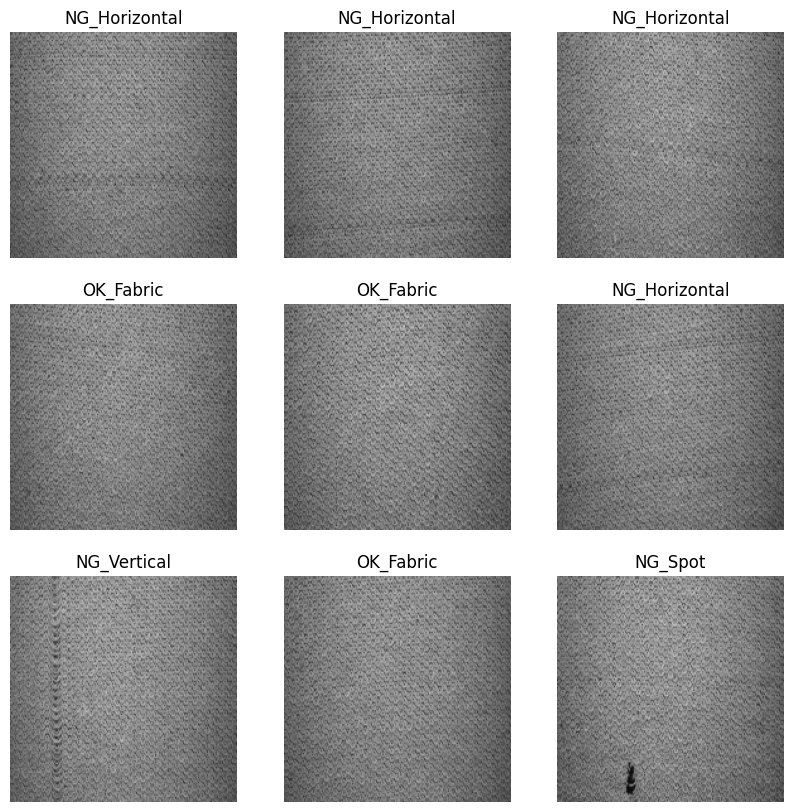

In [7]:
# 確認圖片資訊
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape) # 32張180*180的圖片，最後一個3代表color channels(RGB)
  print(labels_batch.shape)
  break

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# 標準化圖片(因為RGB範圍是在0到255，要縮小至0到1)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("min value:",np.min(first_image))
print("max value:",np.max(first_image))

min value: 0.1311545
max value: 0.76786494


In [10]:
num_classes = len(class_names) # 取得類別數量

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# 編譯模型
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,016,404 (3.88 MB)

 Trainable params: 1,016,404 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 訓練模型
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save("/content/drive/MyDrive/fabric_image_recognition/trained_model.h5")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2738 - loss: 1.4237 - val_accuracy: 0.2125 - val_loss: 1.3866
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2613 - loss: 1.3862 - val_accuracy: 0.2125 - val_loss: 1.3851
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2725 - loss: 1.3849 - val_accuracy: 0.3208 - val_loss: 1.3777
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2768 - loss: 1.3821 - val_accuracy: 0.5542 - val_loss: 1.3157
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5039 - loss: 1.1934 - val_accuracy: 0.5625 - val_loss: 0.7987
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5011 - loss: 0.8681 - val_accuracy: 0.5667 - val_loss: 0.7436
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4905 - loss: 0.8489 - val_accuracy: 0.7167 - val_loss: 0.7162
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5829 - loss: 0.7956 - val_accuracy: 0.5

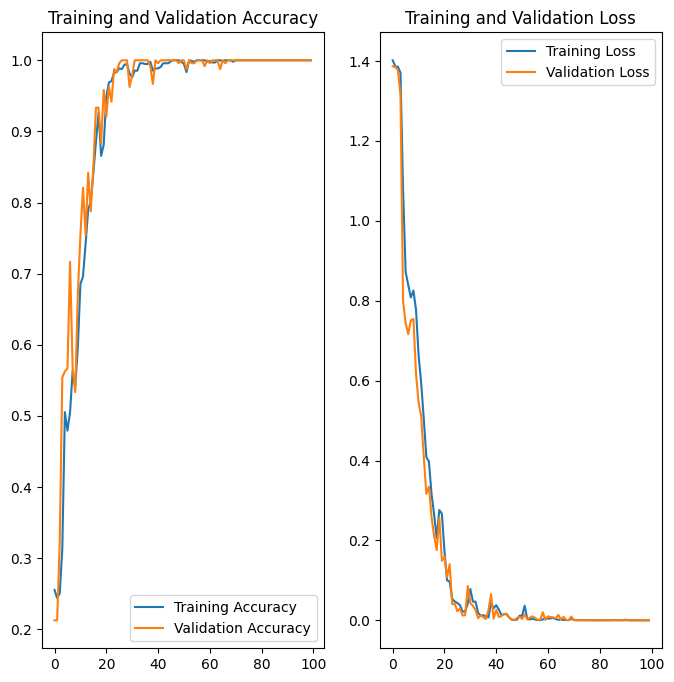

In [13]:
# 獲得訓練精確度、驗證精確度、訓練損失、驗證損失
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# 繪製訓練精確度、驗證精確度圖
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 繪製訓練損失、驗證損失圖
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('/content/drive/MyDrive/fabric_image_recognition/acc_loss.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


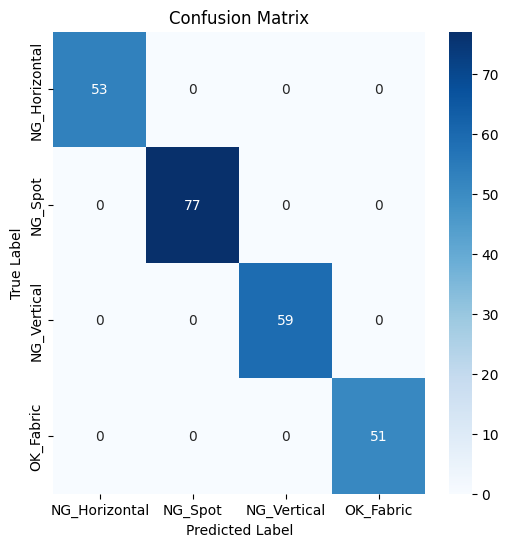

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = []
pred_labels = []

for images, labels in val_ds:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)  # 取得最高機率的類別

  true_labels.extend(labels.numpy())  # 轉成 NumPy 陣列
  pred_labels.extend(predicted_labels)

# 轉成 NumPy 陣列
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# 計算 Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# 繪製 Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/fabric_image_recognition/confusion_matrix.png')
plt.show()